## CENSUS INCOME PREDICTION 

In [1]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer

In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator , BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import functools
from pyspark.ml.feature import OneHotEncoder

In [3]:
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [5]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)
census = hive_context.table("adult_census")
census.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [6]:
census.registerTempTable("census_temp")
hive_context.sql("select * from census_temp").show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [7]:
hive_context.sql("select race from census_temp").show()

+-----+
| race|
+-----+
| race|
|White|
|White|
|White|
|White|
|Black|
|White|
|Black|
|White|
|White|
|White|
|White|
|White|
|White|
|White|
|Black|
|Black|
|White|
|White|
|White|
+-----+
only showing top 20 rows



In [8]:
from pyspark.sql import SQLContext

In [9]:
sql_context=SQLContext(sc)

In [10]:
df = sql_context.sql("SELECT * FROM adult_census")

In [11]:
df.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [12]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  1|        0|     1|        0|            1|             0|         0|           0|   0|  0|           1|           1|             1|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [14]:
df = df.na.drop() 

In [15]:
for col in df.columns:
    print(col,df.select(col).distinct().count())

('age', 73)
('workclass', 9)
('fnlwgt', 21648)
('education', 16)
('education_num', 16)
('marital_status', 7)
('occupation', 15)
('relationship', 6)
('race', 5)
('sex', 2)
('capital_gain', 119)
('capital_loss', 92)
('hours_per_week', 94)
('native_country', 42)
('income', 2)


### CONVERTING TO PANDAS DF FOR VISUALIZATION

In [16]:
df2 = df.toPandas()

In [17]:
df2

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K
5,29,State-gov,204516,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,15,United-States,<=50K
6,35,Private,407913,HS-grad,9,Separated,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K
7,28,Private,96219,Bachelors,13,Married-civ-spouse,Other-service,Wife,White,Female,0,0,15,United-States,<=50K
8,58,Self-emp-inc,78104,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
9,19,?,252292,HS-grad,9,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K


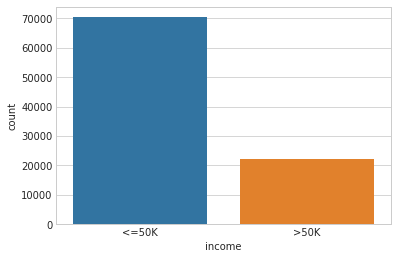

In [39]:
sn.countplot(df2['income'])
plt.show()

In [18]:
df2.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

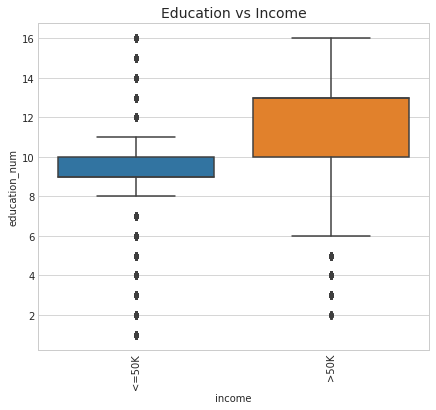

In [34]:
plt.figure(figsize=(7,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['education_num'])
plt.xticks(rotation=90)
plt.title('Education vs Income',fontsize=14)
plt.show()


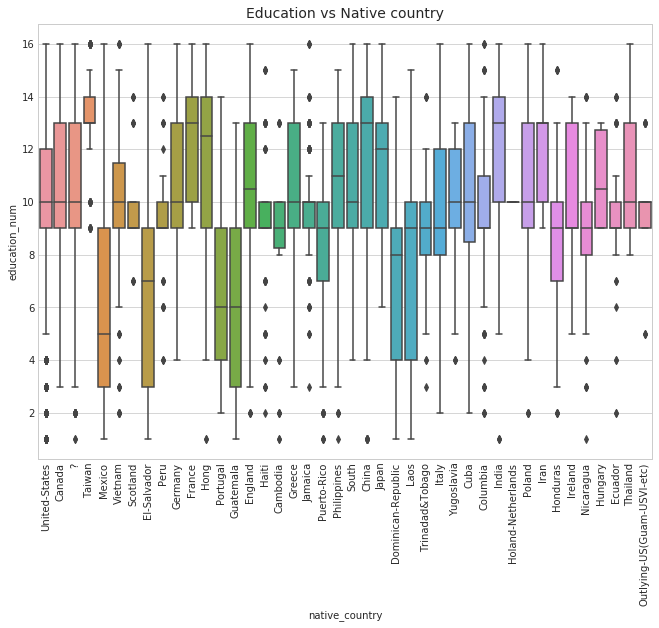

In [35]:
## DISTRIBUTION OF EDUCATION ACROSS DIFFERENT COMMUNITIES
plt.figure(figsize=(11,8))
sn.set_style('whitegrid')
sn.boxplot(df2['native_country'],df2['education_num'])
plt.xticks(rotation=90)
plt.title('Education vs Native country',fontsize=14)
plt.show()

## JAPAN, INDIA, FRANCE, HONGKONG AMONG HIGHEST EDUCATED IN USA
## MEDIAN OF THESE COUNTRIES HIGHER THAN US CITIZENS

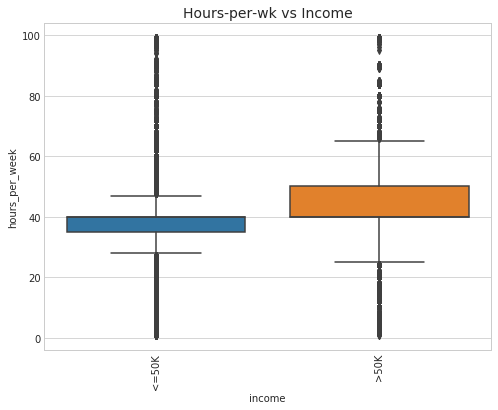

In [36]:
plt.figure(figsize=(8,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['hours_per_week'])
plt.xticks(rotation=90)
plt.title('Hours-per-wk vs Income',fontsize=14)
plt.show()

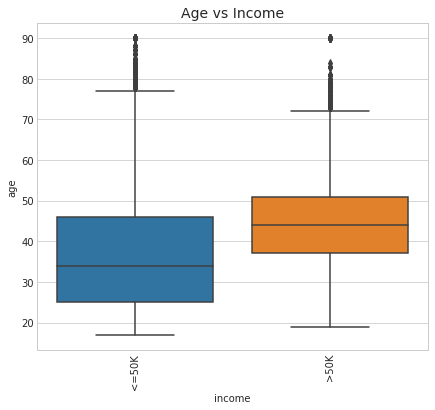

In [37]:
plt.figure(figsize=(7,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['age'])
plt.xticks(rotation=90)
plt.title('Age vs Income',fontsize=14)
plt.show()

### ANALYSING TRENDS FOR INCOME <=50K

In [42]:
df3 = df2[df2['income']=='<=50K']

In [43]:
df3

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K
5,29,State-gov,204516,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,15,United-States,<=50K
6,35,Private,407913,HS-grad,9,Separated,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K
7,28,Private,96219,Bachelors,13,Married-civ-spouse,Other-service,Wife,White,Female,0,0,15,United-States,<=50K
8,58,Self-emp-inc,78104,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
9,19,?,252292,HS-grad,9,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K


In [48]:
df4 = df3.groupby('race')[['income']].count()
df4

,income
race,
Amer-Indian-Eskimo,788
Asian-Pac-Islander,2147
Black,7819
Other,689
White,58965


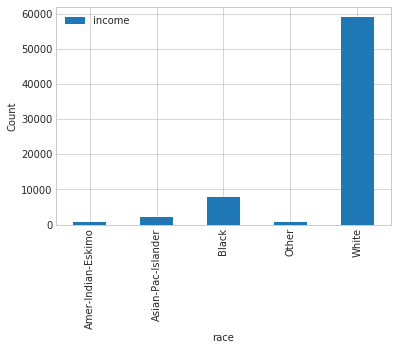

In [57]:
df4.plot.bar()
plt.ylabel('Count')
plt.show()

## WHITES FORM A MAJORITY OF POPULATION WITH INCOME LESS THAN 50K

In [100]:
df4 = df3.groupby(['race','sex'])[['income']].count().unstack()

In [101]:
df4

income       
sex                Female   Male
race                            
Amer-Indian-Eskimo    307    481
Asian-Pac-Islander    869   1278
Black                4174   3645
Other                 298    391
White               21672  37293

In [104]:
plt.style.available

[u'seaborn-darkgrid',
 u'Solarize_Light2',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn',
 u'seaborn-poster',
 u'seaborn-bright',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'fast',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

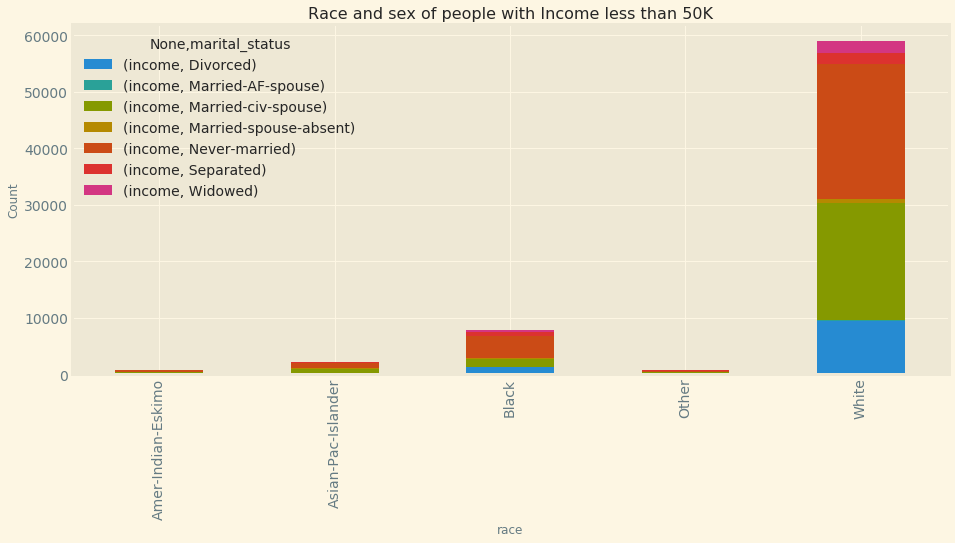

In [111]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Race and sex of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

## MAJORITY OF WHITE MALES 

In [110]:
df4 = df3.groupby(['race','marital_status'])[['income']].count().unstack()
df4

income                                       \
marital_status     Divorced Married-AF-spouse Married-civ-spouse   
race                                                               
Amer-Indian-Eskimo    153.0               NaN              264.0   
Asian-Pac-Islander    170.0               NaN              770.0   
Black                1210.0               NaN             1535.0   
Other                  72.0               NaN              235.0   
White                9491.0              37.0            20776.0   

                                                                          
marital_status     Married-spouse-absent Never-married Separated Widowed  
race                                                                      
Amer-Indian-Eskimo                  21.0         281.0      37.0    32.0  
Asian-Pac-Islander                 108.0        1009.0      36.0    54.0  
Black                              166.0        3777.0     762.0   369.0  
Other                               41.0         283.0      37.0    21.0  
White                              748.0       23865.0    1951.0  2097.0

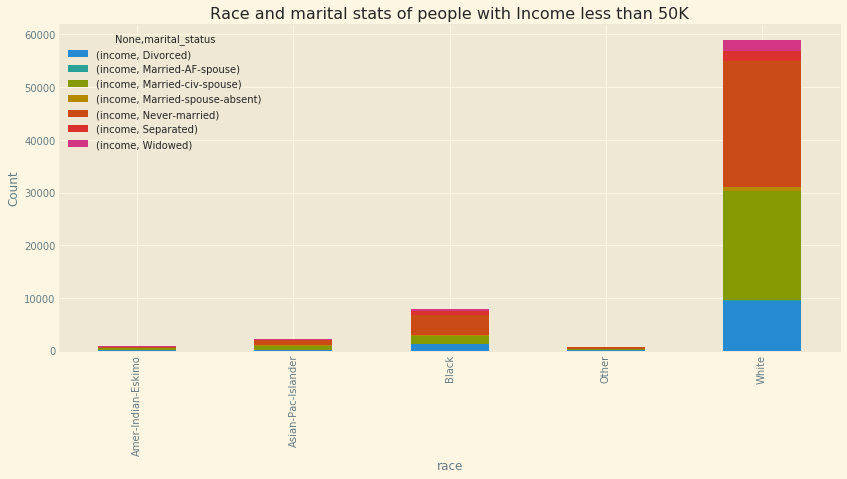

In [64]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Race and marital stats of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

## MAJORITY OF NEVER MARRIED OR MARRIED WITH SPOUSE ABSENT 

In [82]:
df4 = df3.groupby(['education','sex'])[['income']].count().unstack()
df4

income       
sex          Female   Male
education                 
10th            839   1605
11th           1203   2042
12th            390    757
1st-4th         138    337
5th-6th         230    671
7th-8th         447   1276
9th             369   1004
Assoc-acdm     1045   1179
Assoc-voc      1265   1678
Bachelors      3687   5279
Doctorate       108    186
HS-grad        8971  16193
Masters        1035   1137
Preschool        33    107
Prof-school     151    280
Some-college   7409   9357

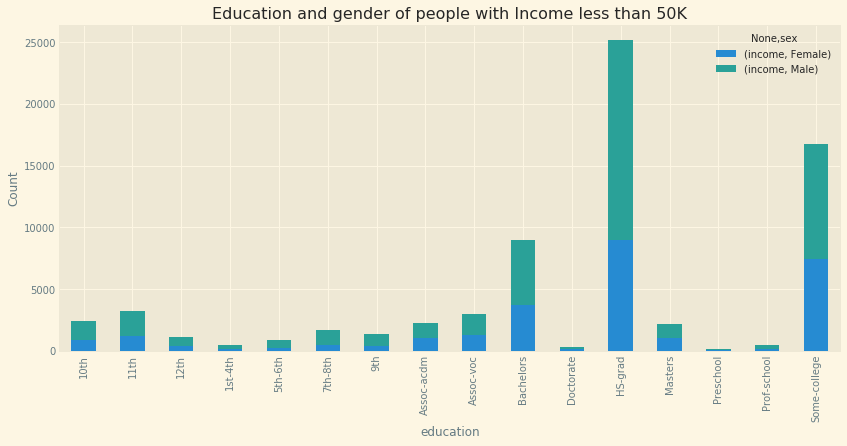

In [84]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Education and gender of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

In [66]:
df3['education'].value_counts()

HS-grad         25164
Some-college    16766
Bachelors        8966
11th             3245
Assoc-voc        2943
10th             2444
Assoc-acdm       2224
Masters          2172
7th-8th          1723
9th              1373
12th             1147
5th-6th           901
1st-4th           475
Prof-school       431
Doctorate         294
Preschool         140
Name: education, dtype: int64

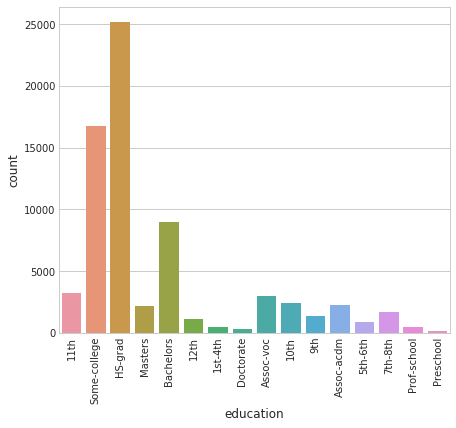

In [81]:
plt.figure(figsize=(7,6))
sn.countplot(df3['education'])
plt.xticks(rotation=90)
plt.show()

## MOSTLY HS GRAD OR SOME COLLEGE

In [87]:
df2['income'].dtypes

dtype('O')

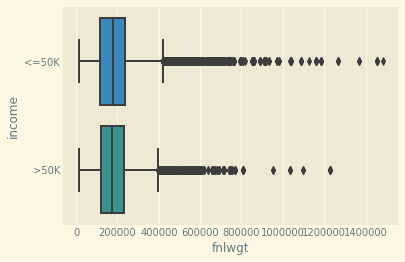

In [91]:
sn.boxplot(df2['fnlwgt'],df2['income'])
plt.show()

### NO EFFECT OF FNLWGT ON INCOME

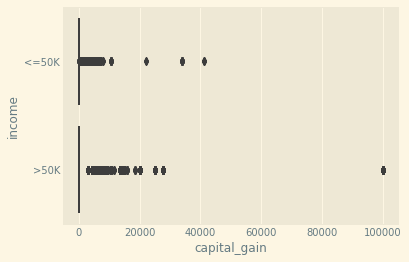

In [93]:
sn.boxplot(df2['capital_gain'],df2['income'])
plt.show()

In [94]:
df2 = df2[df2['capital_gain']<35000]

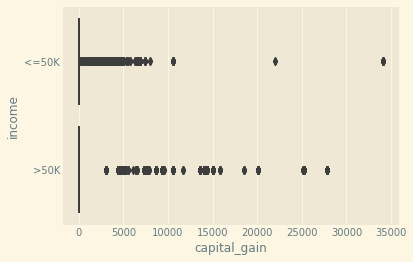

In [98]:
df2['capital_gain'].describe()

count    92126.000000
mean       582.248410
std       2525.800529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      34095.000000
Name: capital_gain, dtype: float64

In [99]:
df2['capital_gain'].median()

0.0

### MODEL BUILDING

In [24]:
df.select('education_num').show()

+-------------+
|education_num|
+-------------+
|            7|
|           10|
|            9|
|            9|
|           10|
|           14|
|            9|
|           13|
|            9|
|            9|
|            9|
|           15|
|           14|
|           13|
|            9|
|           10|
|            7|
|            9|
|           13|
|            9|
+-------------+
only showing top 20 rows



In [119]:
indexer = StringIndexer(inputCol = 'marital_status', outputCol = 'MSI')
indexed_df = indexer.fit(df).transform(df)
indexed_df.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|MSI|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|7.0|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|1.0|
|  77|Self-emp-not-inc|138714|Some-college|       

In [120]:
indexed_df.select('race').show()

+-----+
| race|
+-----+
| race|
|White|
|White|
|White|
|White|
|Black|
|White|
|Black|
|White|
|White|
|White|
|White|
|White|
|White|
|White|
|Black|
|Black|
|White|
|White|
|White|
+-----+
only showing top 20 rows



In [121]:
indexer = StringIndexer(inputCol = 'race', outputCol = 'RCI')
indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+---+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|MSI|RCI|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+---+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|7.0|5.0|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|1.0|0.0|
|  77|Self-emp-not-inc|138714|

In [123]:
indexer = StringIndexer(inputCol = 'workclass', outputCol = 'WCI')
indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+---+---+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|MSI|RCI|WCI|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+---+---+---+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|7.0|5.0|9.0|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|1.0|0.0|0.0|
|  77|Self

In [124]:
indexer = StringIndexer(inputCol = 'occupation', outputCol = 'OCI')
indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df.select('OCI').show()

+----+
| OCI|
+----+
|15.0|
| 5.0|
| 4.0|
| 7.0|
| 2.0|
| 3.0|
| 1.0|
| 5.0|
| 5.0|
| 2.0|
| 7.0|
| 0.0|
| 1.0|
| 2.0|
| 1.0|
|12.0|
| 3.0|
|10.0|
| 6.0|
| 2.0|
+----+
only showing top 20 rows



In [125]:
indexer = StringIndexer(inputCol = 'relationship', outputCol = 'RLI')
indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df.select('RLI').show()

+---+
|RLI|
+---+
|6.0|
|5.0|
|0.0|
|3.0|
|2.0|
|2.0|
|0.0|
|1.0|
|4.0|
|0.0|
|2.0|
|0.0|
|0.0|
|0.0|
|0.0|
|5.0|
|0.0|
|2.0|
|0.0|
|0.0|
+---+
only showing top 20 rows



In [126]:
indexer = StringIndexer(inputCol = 'income', outputCol = 'ICI')
indexed_df = indexer.fit(indexed_df).transform(indexed_df)
indexed_df.select('ICI').show()

+---+
|ICI|
+---+
|2.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|1.0|
|1.0|
|0.0|
|0.0|
|0.0|
|0.0|
|0.0|
|1.0|
+---+
only showing top 20 rows



In [127]:
indexed_df.select('hours_per_week').show()

+--------------+
|hours_per_week|
+--------------+
|          null|
|            40|
|            40|
|            40|
|            45|
|            36|
|            15|
|            40|
|            15|
|            45|
|            40|
|            50|
|            25|
|            47|
|            50|
|            40|
|            40|
|            20|
|            50|
|            50|
+--------------+
only showing top 20 rows



In [128]:
indexed_df2 = indexed_df.na.drop(how='any')

In [129]:
indexed_df2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- MSI: double (nullable = true)
 |-- RCI: double (nullable = true)
 |-- WCI: double (nullable = true)
 |-- OCI: double (nullable = true)
 |-- RLI: double (nullable = true)
 |-- ICI: double (nullable = true)



In [149]:
featureassembler = VectorAssembler(inputCols=['age','WCI','education_num','MSI','OCI','RLI','hours_per_week','capital_gain','capital_loss'],
                                  outputCol='Independent Features')

In [150]:
output = featureassembler.transform(indexed_df2)

In [151]:
indexed_df2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- MSI: double (nullable = true)
 |-- RCI: double (nullable = true)
 |-- WCI: double (nullable = true)
 |-- OCI: double (nullable = true)
 |-- RLI: double (nullable = true)
 |-- ICI: double (nullable = true)



In [152]:
finalized_data = output.select('Independent Features','ICI')

In [153]:
finalized_data.show()

+--------------------+---+
|Independent Features|ICI|
+--------------------+---+
|[22.0,0.0,7.0,1.0...|0.0|
|[77.0,1.0,10.0,0....|0.0|
|[47.0,3.0,9.0,4.0...|0.0|
|[23.0,0.0,9.0,1.0...|0.0|
|[46.0,0.0,10.0,1....|0.0|
|[29.0,4.0,14.0,0....|0.0|
|[35.0,0.0,9.0,3.0...|0.0|
|[28.0,0.0,13.0,0....|0.0|
|[58.0,5.0,9.0,0.0...|0.0|
|[19.0,3.0,9.0,1.0...|0.0|
|(9,[0,2,6],[32.0,...|0.0|
|[67.0,1.0,15.0,0....|1.0|
|[47.0,4.0,14.0,0....|1.0|
|[36.0,2.0,13.0,0....|0.0|
|[29.0,0.0,9.0,1.0...|0.0|
|[26.0,6.0,10.0,0....|0.0|
|[17.0,1.0,7.0,1.0...|0.0|
|[28.0,0.0,9.0,0.0...|0.0|
|(9,[0,2,4,6],[37....|1.0|
|[60.0,3.0,9.0,0.0...|1.0|
+--------------------+---+
only showing top 20 rows



In [154]:
train_data,test_data = finalized_data.randomSplit([.75,.25])

In [155]:
regressor = LogisticRegression(featuresCol = 'Independent Features',labelCol='ICI')

In [156]:
fit_model = regressor.fit(train_data)
results = fit_model.transform(test_data)

In [157]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='ICI')
results.select('ICI','prediction')
AUC = my_eval.evaluate(results)
print("AUC score is : ",AUC)

('AUC score is : ', 0.7307313640061263)


In [158]:
results_pd = results.toPandas()
results_pd

,Independent Features,ICI,rawPrediction,probability,prediction
0,"(22.0, 1.0, 9.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0)",0.0,"[5.662896992705777, 4.460998542248165, -10.123...","[0.7688622527683007, 0.23113764014595548, 1.07...",0.0
1,"(22.0, 5.0, 10.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.430077539122552, 3.993381279678377, -9.4234...","[0.8079422956918728, 0.19205741817280897, 2.86...",0.0
2,"(22.0, 5.0, 10.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.430077539122552, 3.993381279678377, -9.4234...","[0.8079422956918728, 0.19205741817280897, 2.86...",0.0
3,"(25.0, 1.0, 9.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.270882986868751, 3.5149131543540535, -8.785...","[0.8527036200504128, 0.1472957099725353, 6.699...",0.0
4,"(25.0, 2.0, 9.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0)",0.0,"[5.260809376296953, 3.468687384908607, -8.7294...","[0.8571866249309257, 0.1428126553506339, 7.197...",0.0
5,"(26.0, 1.0, 5.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.046680259052359, 2.063467593256004, -7.1101...","[0.9518051848544087, 0.04818981589737827, 4.99...",0.0
6,"(26.0, 1.0, 5.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.046680259052359, 2.063467593256004, -7.1101...","[0.9518051848544087, 0.04818981589737827, 4.99...",0.0
7,"(26.0, 1.0, 9.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.279507044770631, 3.5651869235966642, -8.844...","[0.8473952572143884, 0.15260412045169872, 6.22...",0.0
8,"(27.0, 1.0, 5.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0)",0.0,"[5.055304316954239, 2.1137413624986148, -7.169...","[0.9498587824117338, 0.05013655431039812, 4.66...",0.0
9,"(27.0, 2.0, 6.0, 0.0, 0.0, 0.0, 60.0, 0.0, 0.0)",0.0,"[5.563112200308943, 3.649542790822474, -9.2126...","[0.8714193309559864, 0.1285803354693684, 3.335...",0.0
